# PinaColADA Phase 2 Notebook 

The Youniverse dataset consists of 3 main sub-datasets : the channel dataset, the video dataset and the timeseries data.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Importing data 

For this phase we only use the channels dataset and the timeseries dataset

In [76]:
channels = pd.read_csv('data/df_channels_en.tsv.gz', compression='gzip', sep = '\t')
channels['join_date']= pd.to_datetime(channels['join_date'])
channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [77]:
timeseries = pd.read_csv('data/df_timeseries_en.tsv.gz', compression='gzip', sep = '\t')
timeseries['datetime']= pd.to_datetime(timeseries['datetime'])
timeseries['delta_views'] = timeseries['delta_views'].round(decimals = 3)
timeseries['subs'] = timeseries['subs'].round(decimals = 3)
timeseries['delta_subs'] = timeseries['delta_subs'].round(decimals = 3)
timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000,650.222,0.000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111,1046.000,395.778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083,1501.500,455.500,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250,1750.000,248.500,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600,2008.300,258.300,6,0,0


### Channel data exploration

In [78]:
channels.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


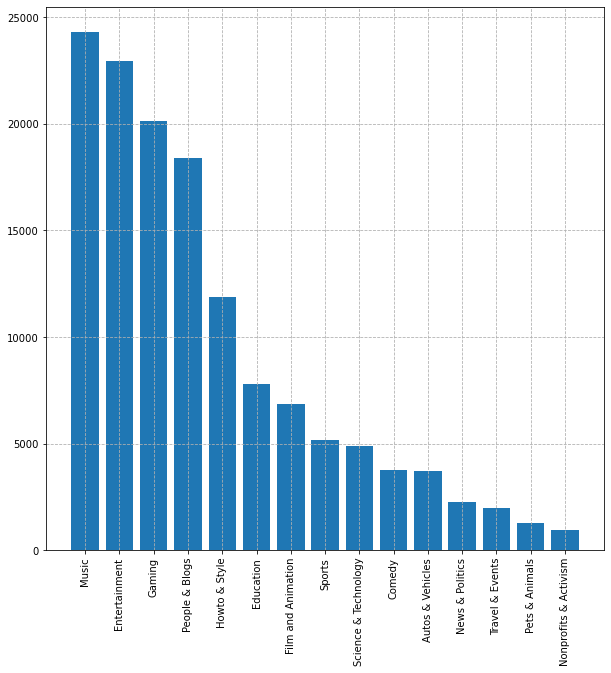

In [81]:
# Group the channels by categories
categories = channels.groupby(['category_cc']).size().to_frame()
categories.rename(columns={0:'count'}, inplace=True)

# Sort and plot the resulting data
categories.sort_values(by='count', ascending=False, inplace=True)
plt.figure(figsize=(10,10))
plt.grid(linestyle='--')
plt.bar(categories.index, categories['count'])
plt.xticks(rotation = 90)
plt.show()


We can see that there is a minority of categories that concentrate a large part of the channels: this can be explained by the fact that these are categories with much broader subjects than others (such as for example Entertainment compared to Pets & Animals) but also by the fact that some can be used by actors fondamentally different than typical Youtube content creators (like Music with artist channels).


In [ ]:
# Power law definition : required for fitting the data
def power_law(x, a, k):
    return a * (x ** k)

In [ ]:
# For each category to plot :
power_law_cat = ['subscribers_cc', 'videos_cc']
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for idx, cat in enumerate(power_law_cat):
    
    # Group the data into bins
    array_hist = ax[idx].hist(channels[cat], bins=5000,log=True,cumulative=-1,histtype='step')
    ax[idx].clear()
    
    # Fit the data to find a suitable power law
    popt, pcov = curve_fit(power_law,array_hist[1][1:],  array_hist[0])
    
    # Plot both the data and the fitted function
    ax[idx].loglog(array_hist[1][1:],array_hist[0], label='data')
    ax[idx].loglog(array_hist[1][1:], power_law(array_hist[1][1:], *popt), 'r-', label='power law fit (k=%.3f)' % tuple(popt)[1])
    ax[idx].set_title(f'{cat} distribution ')
    ax[idx].set_ylabel('# of channels (in log scale)')
    ax[idx].set_xlabel(f'{cat} (in log scale)')
    ax[idx].legend()

plt.show()
                                                                              

The subscribers count follows a power law : the vast majority of Youtube channels have a low number of subscribers while only a few channel concentrate the major part of subscriptions.
We can also make this statement about the number of published videos per channels

In [ ]:
# Count the value of join_date 
creation_dt_df = channels['join_date'].value_counts().to_frame()

# Add missing values (if there was no channel created during a certain month we have to add 0-entry to our dataframe)
idx = pd.date_range(creation_dt_df.index.min(), creation_dt_df.index.max())
creation_dt_df.index = pd.DatetimeIndex(creation_dt_df.index)
creation_dt_df = creation_dt_df.reindex(idx, fill_value=0)

# Group the data by year and month to get an approrpiate scale
creation_dt_df = creation_dt_df.groupby([(creation_dt_df.index.year), (creation_dt_df.index.month)]).sum()

# Plot the final dataset 
creation_dt_df.plot(kind='line',figsize=(10,5), grid='--', legend=False, rot=45, marker=".")
plt.title('Number of created channels over time (every month)')
plt.ylabel('# of channels')
plt.xlabel('Time (per month)')
plt.show()

We can see that there is a considerable attraction for Youtube from its creation in 2005 and in the 2010s followed by a significant drop from 2017 where less and less channels are created.